In [31]:
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split

In [33]:
plant_df = pd.read_csv("Plant_1_Generation_Data.csv")
plant_df.head()


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [34]:
plant_df.shape

(68778, 7)

In [35]:
plant_df_columns = plant_df.columns.tolist()
plant_df[plant_df_columns].isnull().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

In [36]:
## Preprocessing

In [37]:
plant_df['DATE_TIME']= pd.to_datetime(plant_df['DATE_TIME'],format='%d-%m-%Y %H:%M') 

In [38]:
SOURCE_KEY_list = plant_df['SOURCE_KEY'].unique()
day_of_month_list = plant_df['DATE_TIME'].dt.day.unique()
month_list = plant_df['DATE_TIME'].dt.month.unique()

In [54]:
def data_collection():
    df_list = []
    for i in day_of_month_list:
        for j in month_list:
            df = plant_df[(plant_df.DATE_TIME.dt.month == j) & (plant_df.DATE_TIME.dt.day == i)][-len(SOURCE_KEY_list):]
            df = df.drop(['PLANT_ID', 'DC_POWER', 'AC_POWER', 'TOTAL_YIELD'], axis=1)
            df = df[df.DAILY_YIELD != 0]
            df_list.append(df)
    main_df = pd.concat(df_list, ignore_index=True)
    return main_df

main_df = data_collection()


In [55]:
main_df.index = pd.to_datetime(main_df['DATE_TIME']).dt.normalize()
main_df = main_df.drop(['DATE_TIME'], axis=1)


In [56]:
main_df.head()


,SOURCE_KEY,DAILY_YIELD
DATE_TIME,,
2020-05-15,1BY6WEcLGh8j5v7,5754.0
2020-05-15,McdE0feGgRqW7Ca,6471.0
2020-05-15,YxYtjZvoooNbGkE,6291.0
2020-05-15,ZoEaEvLYb1n2sOq,6261.0
2020-05-15,bvBOhCH3iADSZry,5707.0


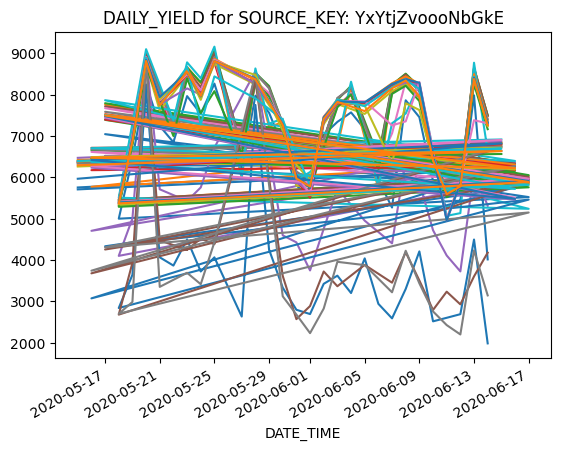

In [57]:
import matplotlib.pyplot as plt

# Get all unique (unfaulty) source keys
Unfault_SOURCE_KEY = main_df.SOURCE_KEY.unique()

# Plot daily yield for each source key
for i in SOURCE_KEY_list:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot(title=f'DAILY_YIELD for SOURCE_KEY: {i}')

plt.show()


In [59]:
main_df['dayofweek'] = main_df.index.dayofweek
main_df['quarter'] = main_df.index.quarter
main_df['month'] = main_df.index.month
main_df['year'] = main_df.index.year
main_df['dayofyear'] = main_df.index.dayofyear
main_df['dayofmonth'] = main_df.index.day
main_df['weekofyear'] = main_df.index.isocalendar().week


In [60]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

label_encoder = preprocessing.LabelEncoder() 
main_df['SOURCE_KEY'] = label_encoder.fit_transform(main_df['SOURCE_KEY'])

X = main_df[['SOURCE_KEY', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = main_df['DAILY_YIELD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [61]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

label_encoder = preprocessing.LabelEncoder()
main_df['SOURCE_KEY'] = label_encoder.fit_transform(main_df['SOURCE_KEY'])

X = main_df[['SOURCE_KEY', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = main_df['DAILY_YIELD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [71]:
import xgboost as xgb

# Convert to DMatrix (XGBoost's internal format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.16,
    'colsample_bytree': 0.6,
    'max_depth': 5,
    'min_child_weight': 6,
    'eval_metric': 'rmse'
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)


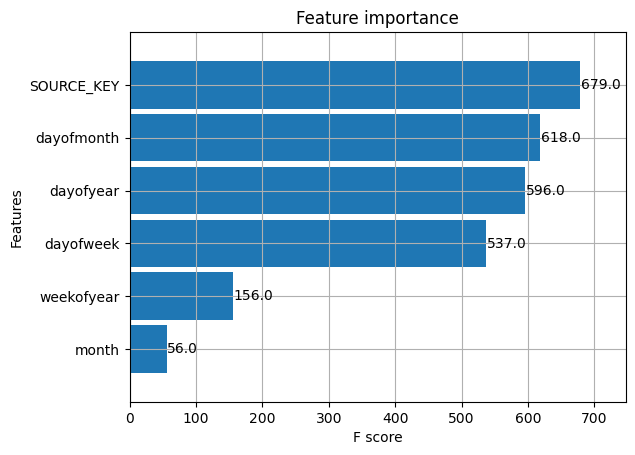

In [73]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, height=0.9)
plt.show()


In [75]:
# Convert test features to DMatrix
dtest = xgb.DMatrix(X_test)

# Predict using the trained model
y_pred = model.predict(dtest)


In [76]:
#predictions
# n = number of days to predict future generation
def create_df(n):
    prediction_df = pd.DataFrame()
    for i in range(0,n):
        df = pd.DataFrame()
        df["SOURCE_KEY"] = Unfault_SOURCE_KEY
        df["DATE_TIME"] = "2020-06-%d"%(i+15)
        prediction_df = prediction_df.append(df)
    prediction_df['DATE_TIME']= pd.to_datetime(prediction_df['DATE_TIME']) 
    prediction_df.index = prediction_df.DATE_TIME.dt.date.astype("datetime64[ns]")
    prediction_df = prediction_df.drop(["DATE_TIME"],axis=1)
    prediction_df['dayofweek'] = prediction_df.index.dayofweek
    prediction_df['quarter'] = prediction_df.index.quarter
    prediction_df['month'] = prediction_df.index.month
    prediction_df['year'] = prediction_df.index.year
    prediction_df['dayofyear'] = prediction_df.index.dayofyear
    prediction_df['dayofmonth'] = prediction_df.index.day
    prediction_df['weekofyear'] = prediction_df.index.week
    return prediction_df


In [49]:
#predictions
# n = number of days to predict future generation
def create_df(n):
    prediction_df = pd.DataFrame()
    for i in range(0,n):
        df = pd.DataFrame()
        df["SOURCE_KEY"] = Unfault_SOURCE_KEY
        df["DATE_TIME"] = "2020-06-%d"%(i+15)
        prediction_df = prediction_df.append(df)
    prediction_df['DATE_TIME']= pd.to_datetime(prediction_df['DATE_TIME']) 
    prediction_df.index = prediction_df.DATE_TIME.dt.date.astype("datetime64[ns]")
    prediction_df = prediction_df.drop(["DATE_TIME"],axis=1)
    prediction_df['dayofweek'] = prediction_df.index.dayofweek
    prediction_df['quarter'] = prediction_df.index.quarter
    prediction_df['month'] = prediction_df.index.month
    prediction_df['year'] = prediction_df.index.year
    prediction_df['dayofyear'] = prediction_df.index.dayofyear
    prediction_df['dayofmonth'] = prediction_df.index.day
    prediction_df['weekofyear'] = prediction_df.index.week
    return prediction_df

In [78]:
def create_df(n):
    prediction_dfs = []  # use a list to collect DataFrames

    for i in range(n):
        df = pd.DataFrame()
        df["SOURCE_KEY"] = Unfault_SOURCE_KEY
        df["DATE_TIME"] = f"2020-06-{i+15:02d}"  # ensures two-digit day format
        prediction_dfs.append(df)

    # Concatenate all at once
    prediction_df = pd.concat(prediction_dfs, ignore_index=True)

    # Convert DATE_TIME to datetime and set index
    prediction_df['DATE_TIME'] = pd.to_datetime(prediction_df['DATE_TIME'])
    prediction_df.index = prediction_df.DATE_TIME.dt.date.astype("datetime64[ns]")
    prediction_df = prediction_df.drop(["DATE_TIME"], axis=1)

    return prediction_df


In [80]:
x = create_df(2)  # Or however many days you want


In [85]:
# Only use known source keys
x = x[x['SOURCE_KEY'].isin(label_encoder.classes_)]



In [86]:
x['dayofweek'] = x.index.dayofweek
x['quarter'] = x.index.quarter
x['month'] = x.index.month
x['year'] = x.index.year
x['dayofyear'] = x.index.dayofyear
x['dayofmonth'] = x.index.day
x['weekofyear'] = x.index.isocalendar().week


In [89]:
# Train the model
reg = xgb.XGBRegressor(
    n_estimators=500,
    objective='reg:squarederror',
    learning_rate=0.16,
    colsample_bytree=0.6,
    max_depth=5,
    min_child_weight=6
)

# Fit the model
reg.fit(X_train, y_train)

# Now predict
y_prediction = reg.predict(x)


In [92]:
# Example (make sure you have this step working)
reg.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
print(len(y_prediction))        # Should match len(df_copy)
print(len(df_copy.index))       # Should be the same


0
44


In [96]:
df_copy


,SOURCE_KEY
DATE_TIME,
2020-06-15,1BY6WEcLGh8j5v7
2020-06-15,McdE0feGgRqW7Ca
2020-06-15,YxYtjZvoooNbGkE
2020-06-15,ZoEaEvLYb1n2sOq
2020-06-15,bvBOhCH3iADSZry
2020-06-15,iCRJl6heRkivqQ3
2020-06-15,pkci93gMrogZuBj
2020-06-15,rGa61gmuvPhdLxV
2020-06-15,sjndEbLyjtCKgGv
